In [49]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import random
import re

In [2]:
test_data = pd.read_csv('./raw_data/test_data.csv')

决策树分类所需特征:month,max_T,min_T,avg_T

In [3]:
test_day_info = test_data.groupby('date')[['avg_T']].mean()

In [4]:
test_day_info['max_T'] = None
test_day_info['min_T'] = None

In [5]:
for name,group in test_data.groupby(['date']):
    test_day_info.loc[name,'max_T'] = group['max_T'].max()
    test_day_info.loc[name,'min_T'] = group['min_T'].min()

In [7]:
test_day_info['date'] = test_day_info.index

In [8]:
test_day_info['date'] = pd.to_datetime(test_day_info['date'])

In [9]:
test_day_info['month'] = test_day_info['date'].map(lambda x:x.month)

In [10]:
test_day_info.drop(columns=['date'],inplace=True)

In [12]:
test_day_info['max_T']  = pd.to_numeric(test_day_info['max_T'])
test_day_info['min_T']  = pd.to_numeric(test_day_info['min_T'])

In [13]:
test_day_info = test_day_info[['month','max_T','min_T','avg_T']]

加载训练好的分类器

In [14]:
import joblib

In [15]:
lgb_clf = joblib.load('./raw_data/lgb_clf.pkl')

In [16]:
test_data_label = lgb_clf.predict(test_day_info)

In [17]:
test_day_info['class'] = None

F:\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [18]:
test_day_info['class'] = test_data_label

F:\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [19]:
test_day_info = test_day_info.reset_index()

In [20]:
test_day_info = test_day_info[['date','class']]

In [25]:
test_data = pd.merge(test_data,test_day_info,how='left')

特征处理

In [26]:
last_second_week_power = test_data[:-48*14].Power
last_week_power = test_data[48*7:-48*7].Power
last_second_week_power.reset_index(drop=True,inplace=True)
last_week_power.reset_index(drop=True,inplace=True)
df_features = test_data[48*14:].copy()
df_features.reset_index(drop=True,inplace=True)
df_features['last_second_week_power'] = last_second_week_power
df_features['last_week_power'] = last_week_power

In [27]:
last_n_hour_temperature = {}
for i in range(1,7):
    last_hour_temperature = test_data.iloc[48*14-i:-i].min_T.reset_index(drop=True)
    last_n_hour_temperature[i] = last_hour_temperature
for i in range(1,7):
    df_features['last_%d_hour_temperature'%i] = last_n_hour_temperature[i]

In [28]:
yesterday_n_hour_temperature = {}
for i in range(0,4):
    yesterday_hour_temperature = test_data.iloc[48*13-i:-48*1-i].min_T.reset_index(drop=True)
    yesterday_n_hour_temperature[i] = yesterday_hour_temperature 
for i in range(0,4):
    df_features['yesterday_last_%d_hour_temperature'%i] = yesterday_n_hour_temperature[i]

In [29]:
last_second_day_n_hour_temperature = {}
for i in range(0,2):
    last_second_day_hour_temperature = test_data.iloc[48*12-i:-48*2-i].min_T.reset_index(drop=True)
    last_second_day_n_hour_temperature[i] = last_second_day_hour_temperature
for i in range(0,2):
    df_features['last_second_day_%d_hour_temperature'%i] = last_second_day_n_hour_temperature[i]

In [30]:
last_n_hour_dampness = {}
for i in range(1,7):
    last_hour_dampness = test_data.iloc[48*14-i:-i].D.reset_index(drop=True)
    last_n_hour_dampness[i] = last_hour_dampness
for i in range(1,7):
    df_features['last_%d_hour_dampness'%i] = last_n_hour_dampness[i]

In [31]:
yesterday_n_hour_dampness = {}
for i in range(0,4):
    yesterday_hour_dampness = test_data.iloc[48*13-i:-48*1-i].D.reset_index(drop=True)
    yesterday_n_hour_dampness[i] = yesterday_hour_dampness
for i in range(0,4):
    df_features['yesterday_last_%d_hour_dampness'%i] = yesterday_n_hour_dampness[i]

In [32]:
last_second_day_n_hour_dampness = {}
for i in range(0,2):
    last_second_day_hour_dampness = test_data.iloc[48*12-i:-48*2-i].D.reset_index(drop=True)
    last_second_day_n_hour_dampness[i] = last_second_day_hour_dampness
for i in range(0,2):
    df_features['last_second_day_%d_hour_dampness'%i] = last_second_day_n_hour_dampness[i]

In [33]:
last_n_hour_power = {}
for i in range(1,49):
    last_hour_power = test_data.iloc[48*14-i:-i].Power.reset_index(drop=True)
    last_n_hour_power[i] = last_hour_power
for i in range(1,49):
    df_features['last_%d_hour'%i] = last_n_hour_power[i]

In [34]:
df_features['date'] = pd.to_datetime(df_features['date'])

In [35]:
df_features['year'] = df_features.date.map(lambda x: x.year)
df_features['month'] = df_features.date.map(lambda x: x.month)
df_features['day'] = df_features.date.map(lambda x: x.day)
df_features['weekday'] = df_features.date.map(lambda x: x.weekday())
df_features['holiday'] = df_features.weekday.map(lambda x:1 if (x==6 or x==0) else 0)

In [36]:
df_features.to_csv('./raw_data/df_features_test.csv')

In [37]:
df_features['last_hours_temperature'] = (df_features['last_1_hour_temperature']+df_features['last_2_hour_temperature']+df_features['last_3_hour_temperature']+df_features['last_4_hour_temperature']+df_features['last_5_hour_temperature']+df_features['last_6_hour_temperature'])/6

In [38]:
df_features.drop(columns=['last_1_hour_temperature','last_2_hour_temperature',
                          'last_3_hour_temperature','last_4_hour_temperature',
                          'last_5_hour_temperature','last_6_hour_temperature'],inplace=True)

In [39]:
df_features['yesterday_last_hours_temperature'] = (df_features['yesterday_last_0_hour_temperature']+df_features['yesterday_last_1_hour_temperature']+df_features['yesterday_last_2_hour_temperature']+df_features['yesterday_last_3_hour_temperature'])/4
df_features.drop(columns=['yesterday_last_0_hour_temperature','yesterday_last_1_hour_temperature',
                          'yesterday_last_2_hour_temperature','yesterday_last_3_hour_temperature'],
                 inplace=True)

In [40]:
df_features['last_second_day_hours_temperature'] = (df_features['last_second_day_0_hour_temperature']+df_features['last_second_day_1_hour_temperature'])/2
df_features.drop(columns=['last_second_day_0_hour_temperature',
                          'last_second_day_1_hour_temperature'],
        inplace=True)

In [41]:
df_features['last_hours_dampness'] = (df_features['last_1_hour_dampness']+df_features['last_2_hour_dampness']+df_features['last_3_hour_dampness']+df_features['last_4_hour_dampness']+df_features['last_5_hour_dampness']+df_features['last_6_hour_dampness'])/6
df_features.drop(columns=['last_1_hour_dampness','last_2_hour_dampness',
                          'last_3_hour_dampness','last_4_hour_dampness',
                          'last_5_hour_dampness','last_6_hour_dampness',],inplace=True)

df_features['yesterday_last_hours_dampness'] = (df_features['yesterday_last_0_hour_dampness']+df_features['yesterday_last_1_hour_dampness']+df_features['yesterday_last_2_hour_dampness']+df_features['yesterday_last_3_hour_dampness'])/4
df_features.drop(columns=['yesterday_last_0_hour_dampness','yesterday_last_1_hour_dampness',
                          'yesterday_last_2_hour_dampness', 'yesterday_last_3_hour_dampness',],
       inplace=True)

df_features['last_second_day_hours_dampness'] = (df_features['last_second_day_0_hour_dampness']+df_features['last_second_day_1_hour_dampness'])/2
df_features.drop(columns=['last_second_day_0_hour_dampness','last_second_day_1_hour_dampness'],inplace=True)

如何预测？
这里以2010-01-15为例

In [131]:
df_features.to_csv('./raw_data/df_features_test_final.csv')

In [77]:
test_day = df_features[df_features['date']=='2010-01-15'].copy()

In [106]:
y_test = y_test['Power']

In [80]:
test_day.reset_index(inplace=True,drop=True)

In [82]:
test_day.loc[0,'class']

1

class为1,使用类型1模型

In [84]:
test_day.drop(columns=['class'],inplace=True)

In [85]:
test_day.drop(columns=['Power'],inplace=True)

In [86]:
candidate_features = test_day.columns[8:8+48].to_list()

获取模型所需的日候选负荷

In [90]:
importance_features = np.load('./raw_data/class_1_features.npy',allow_pickle=True)

In [92]:
for i in importance_features:
    candidate_features.remove(i)

In [95]:
test_day.drop(columns=candidate_features,inplace=True)

In [113]:
test_day.drop(columns=['year','date'],inplace=True)

In [97]:
model_lgb = joblib.load('./raw_data/model_lgb_1.pkl')

In [101]:
last_hours = []
for i in importance_features:
    num = re.findall('\d+',i)[0]
    last_hours.append(int(num))
last_hours.sort()

In [122]:
preds = []
for i in range(len(test_day)):
    pred = model_lgb.predict(test_day[i:i+1])
    preds.append(pred.item())
    for idx,last_hour in enumerate(last_hours):
        if len(preds) >= last_hour:
            test_day.iloc[i+1:i+2,7+idx:8+idx] = preds[-last_hour]

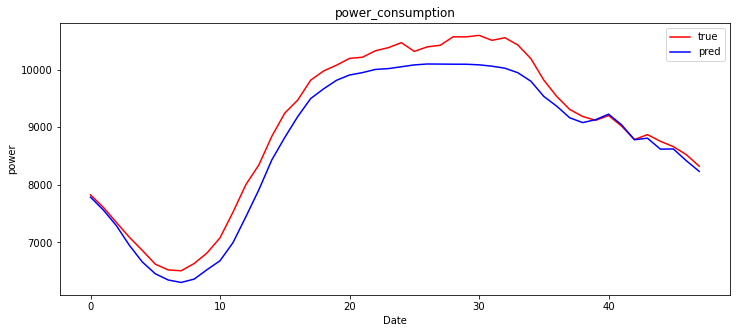

In [125]:
power_data = plt.figure(figsize=(12,5))
ax = power_data.add_subplot(111)
ax.set(title='power_consumption',ylabel='power',xlabel='Date')
plt.plot(y_test,label='true',color='red')
plt.plot(preds,label='pred',color='blue')
plt.legend(loc='best')
plt.show()

In [126]:
from sklearn.metrics import mean_squared_error

In [129]:
mape = (np.abs(y_test - preds)/y_test).mean()*100
print('mape:',mape)
        
rmse = np.sqrt(mean_squared_error(y_test,preds))
print('rmse:',rmse)

mape: 2.881895971323368
rmse: 307.2847336365698


整理为预测函数:

In [145]:
def predict_power(df_features,date_time):
    test_day = df_features[df_features['date']==date_time].copy()
    test_day.reset_index(inplace=True,drop=True)
    
    class_model = test_day.loc[0,'class']
    test_day.drop(columns=['class'],inplace=True)
    if class_model==1:
        importance_features = np.load('./raw_data/class_1_features.npy',allow_pickle=True)
        model_lgb = joblib.load('./raw_data/model_lgb_1.pkl')
    elif class_model==0:
        importance_features = np.load('./raw_data/class_0_features.npy',allow_pickle=True)
        model_lgb = joblib.load('./raw_data/model_lgb_0.pkl')
    
    y_test = test_day['Power']
    test_day.drop(columns=['Power'],inplace=True)
    candidate_features = test_day.columns[8:8+48].to_list()
    for i in importance_features:
        candidate_features.remove(i)
        
    test_day.drop(columns=candidate_features,inplace=True)
    test_day.drop(columns=['year','date'],inplace=True)
    
    last_hours = []
    for i in importance_features:
        num = re.findall('\d+',i)[0]
        last_hours.append(int(num))
    last_hours.sort()
    
    preds = []
    for i in range(len(test_day)):
        pred = model_lgb.predict(test_day[i:i+1])
        preds.append(pred.item())
        for idx,last_hour in enumerate(last_hours):
            if len(preds) >= last_hour:
                test_day.iloc[i+1:i+2,7+idx:8+idx] = preds[-last_hour]
    
    power_data = plt.figure(figsize=(12,5))
    ax = power_data.add_subplot(111)
    ax.set(title='power_consumption',ylabel='power',xlabel='Date')
    plt.plot(y_test,label='true',color='red')
    plt.plot(preds,label='pred',color='blue')
    plt.legend(loc='best')
    plt.show()
    
    mape = (np.abs(y_test - preds)/y_test).mean()*100
    print('mape:',mape)
        
    rmse = np.sqrt(mean_squared_error(y_test,preds))
    print('rmse:',rmse)
    
    del model_lgb,importance_features

若非滚动预测

In [144]:
def predict_power_short(df_features,date_time):
    test_day = df_features[df_features['date']==date_time].copy()
    test_day.reset_index(inplace=True,drop=True)
    
    class_model = test_day.loc[0,'class']
    test_day.drop(columns=['class'],inplace=True)
    if class_model==1:
        importance_features = np.load('./raw_data/class_1_features.npy',allow_pickle=True)
        model_lgb = joblib.load('./raw_data/model_lgb_1.pkl')
    elif class_model==0:
        importance_features = np.load('./raw_data/class_0_features.npy',allow_pickle=True)
        model_lgb = joblib.load('./raw_data/model_lgb_0.pkl')
    
    y_test = test_day['Power']
    test_day.drop(columns=['Power'],inplace=True)
    candidate_features = test_day.columns[8:8+48].to_list()
    for i in importance_features:
        candidate_features.remove(i)
        
    test_day.drop(columns=candidate_features,inplace=True)
    test_day.drop(columns=['year','date'],inplace=True)
    
    last_hours = []
    for i in importance_features:
        num = re.findall('\d+',i)[0]
        last_hours.append(int(num))
    last_hours.sort()
    
    preds = []
    for i in range(len(test_day)):
        pred = model_lgb.predict(test_day[i:i+1])
        preds.append(pred.item())
    
    power_data = plt.figure(figsize=(12,5))
    ax = power_data.add_subplot(111)
    ax.set(title='power_consumption',ylabel='power',xlabel='Date')
    plt.plot(y_test,label='true',color='red')
    plt.plot(preds,label='pred',color='blue')
    plt.legend(loc='best')
    plt.show()
    
    mape = (np.abs(y_test - preds)/y_test).mean()*100
    print('mape:',mape)
        
    rmse = np.sqrt(mean_squared_error(y_test,preds))
    print('rmse:',rmse)
    
    del model_lgb,importance_features

现在就方便多了

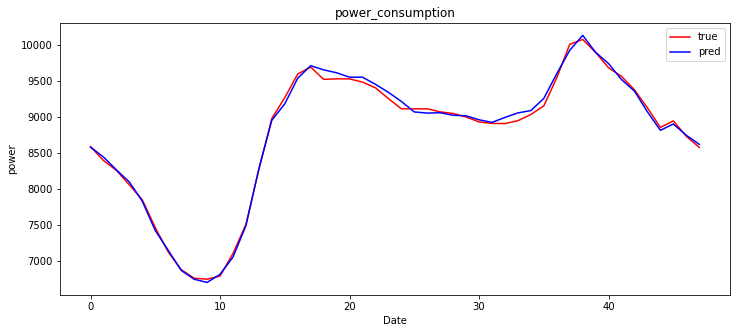

mape: 0.5023269992366308
rmse: 54.25665372083827


In [148]:
predict_power_short(df_features,'2010-09-15')

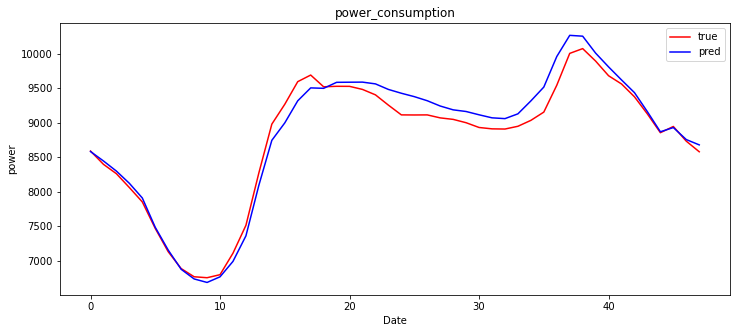

mape: 1.48705993433184
rmse: 168.42508204172947


In [179]:
predict_power(df_features,'2010-09-15')